## Интеллектуальный анализ данных – весна 2022
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

Есть ли пропущенные значение?

In [3]:
(X.isna() | X == '').any(axis=None)

False

Есть ли категориальные переменные?

In [4]:
X.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

In [5]:
X.nunique()

alcohol                         126
malic_acid                      133
ash                              79
alcalinity_of_ash                63
magnesium                        53
total_phenols                    97
flavanoids                      132
nonflavanoid_phenols             39
proanthocyanins                 101
color_intensity                 132
hue                              78
od280/od315_of_diluted_wines    122
proline                         121
dtype: int64

> У всех признаков числовой тип данных и огромное количество уникальных значений, из чего следует, что все признаки количественные

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [6]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train[['alcohol', 'magnesium']]

,alcohol,magnesium
138,13.49,88.0
104,12.51,85.0
78,12.33,136.0
36,13.28,110.0
93,12.29,88.0
...,...,...
71,13.86,86.0
106,12.25,80.0
14,14.38,102.0
92,12.69,80.0


**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train[['alcohol', 'magnesium']])
X_test_norm = normalizer.transform(X_test[["alcohol", "magnesium"]])

neighbour_counts = [1, 3, 5, 10, 15, 25]
classifier = [KNeighborsClassifier(n_neighbors=i).fit(X_train_norm, y_train)
              for i in neighbour_counts]
for i in range(6):
    print(f'{neighbour_counts[i]} Neighbours'
          f'\tTrain: {np.mean(classifier[i].predict(X_train_norm) == y_train):.3}'
          f'\tTest: {np.mean(classifier[i].predict(X_test_norm) == y_test):.3}')

1 Neighbours	Train: 0.992	Test: 0.667
3 Neighbours	Train: 0.839	Test: 0.648
5 Neighbours	Train: 0.806	Test: 0.685
10 Neighbours	Train: 0.806	Test: 0.704
15 Neighbours	Train: 0.782	Test: 0.685
25 Neighbours	Train: 0.726	Test: 0.685


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [8]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [9]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

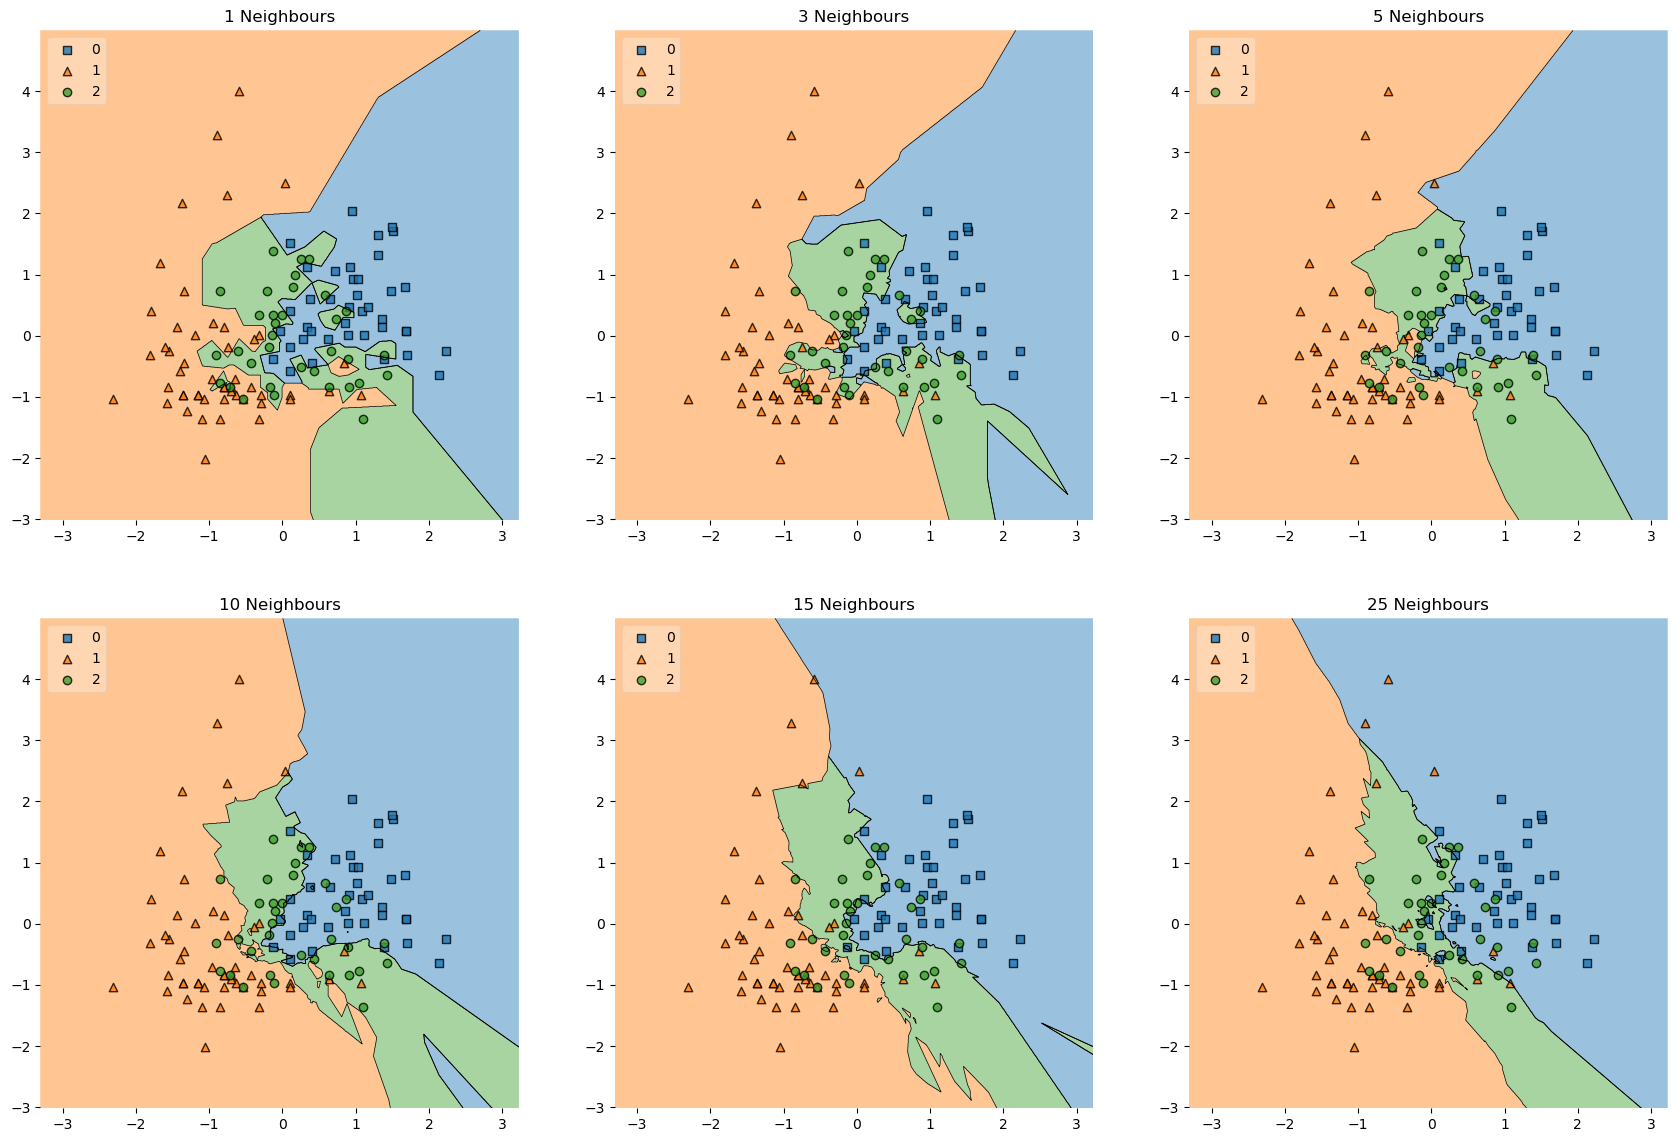

In [10]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(21, 14))

labels = [1, 3, 5, 10, 15, 25]
for clf, lab, grd in zip(classifier,
                         labels,
                         itertools.product([0, 1], [0, 1, 2])):
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_norm, y=y_train, clf=clf, legend=2)
    plt.title(f'{lab} Neighbours')

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

> На обучающей выборке точность уменьшается с увеличением количества соседей. На тестовой наибольшее точность достигается при количестве соседей ~15, вследствие чего было бы логично считать 15 оптимальным значением. Однако решающая поверхность для 15 соседей достаточно рваная (особенно в области правого нижнего угла), что свидетельствует о низкой обобщающей способности. Во многом это проблема самих данных выборки - точки очень тесно сгруппированы, а класс 1 (зеленый) практически целиком перемешан с двумя другими.

> Таким образом, модель с 25 соседями выглядит как более подходящий вариант - ее решающая поверхность более гладкая и "компактная" => лучше обобщающая способность. Даже несмотря на то, что на нашей выборке точность такой модели невысока, на новых данных она скорее всего будет работать гораздо лучше, а разбиение легче интерпретировать.

### Задание 2: Обученная машина.

В этом задании мы рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота.

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз.

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении этого доминирующего класса.

Для лучшего понимания происходящего изобразим возможное положение робота и меток:

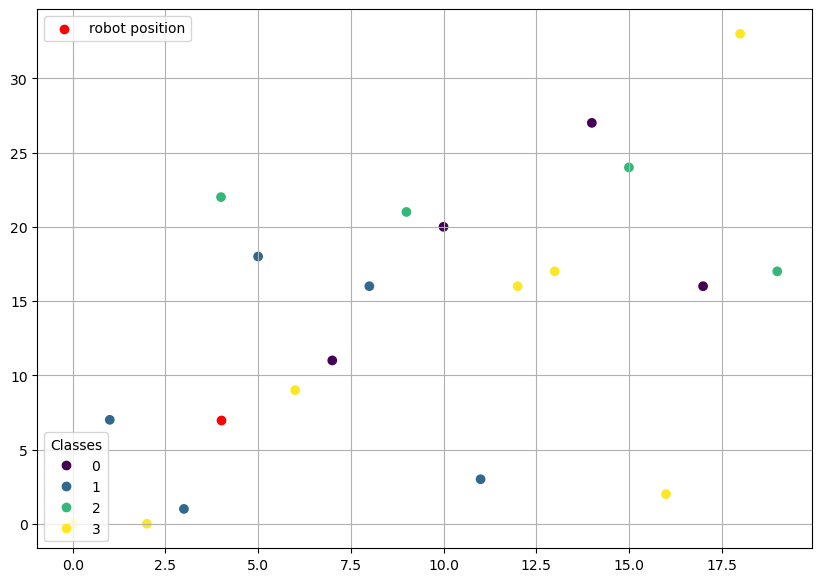

In [11]:
np.random.seed(12345)
x = np.arange(20)
# сгенерируем случайные метки
landmarks = x + np.round(np.random.normal(2, 8, 20))
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(x, landmarks, c=random_classes)
ax.scatter(4, 7, c='r', marker='o', label='robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

На следующем шаге робот передвинется на 1 либо вправо, либо в направлении, которое указывают ближайшие соседи.

**Задача 2.1 (1.5 балла)** Реализуйте класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определите атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определите метод `move()`: рассчитайте новое положение робота по правилам выше и добавьте её в историю перемещений. Подсказка: исходы можно интерпретировать как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания можно использовать, например, `np.random.binomial()` с правильными параметрами.

In [12]:
class MobileRobot():

    def __init__(self, k, initial_position, landmarks, classes):
        '''
        Attributes:
        ------
        k: int
            Number of neighbours

        initial_position: ndarray
            Initial position of the robot as a point, e.g. (-1, 1)

        landmarks: ndarray
            numpy array of shape (n_landmarks, 2) with the euclidean positions of points

        classes: ndarray
            numpy array of shape (n_landmarks, ) with class of landmark for each point in landmarks

        '''
        # Store the history of movements
        self.trajectory = np.array([initial_position])

        # kNN Classifier for determining the classes of landmarks
        self.knn = KNeighborsClassifier(
            n_neighbors=k, metric='euclidean').fit(landmarks, classes)

        # Mapping between classes of points and movements
        self.mapping = {0: np.array([1, 0]),
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}

    def move(self):
        '''
        Calculate new position of the robot and add it to the history
        '''

        if np.random.binomial(n=1, p=0.2):
            d = (1, 0)
        else:
            d = self.mapping[self.knn.predict([self.trajectory[-1]])[0]]

        self.trajectory = np.append(
            self.trajectory, [self.trajectory[-1] + d], axis=0)

**Задача 2.2 (0.5 балла)** Дополните функцию `conduct_experiment`: определите переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [13]:
def conduct_experiment(x,
                       mean=0,
                       std=2,
                       n_movements=10,
                       k=3,
                       initial_position=np.array([10, 20])):
    np.random.seed(12345)
    # Generate random landmarks
    landmarks = np.vstack(
        (x, x + np.round(np.random.normal(mean, std, len(x))))).T

    # Generate random classes of landmarks
    classes = np.random.randint(0, 4, size=len(x))

    # Conduct experiment
    robot = MobileRobot(k, initial_position, landmarks, classes)

    for n in range(n_movements):
        robot.move()

    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c=classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)

    traj = robot.trajectory
    ax.plot(traj[:, 0], traj[:, 1],
            c='r', marker='o', label='robot position')

    plt.plot()
    _ = plt.legend()
    _ = plt.grid()

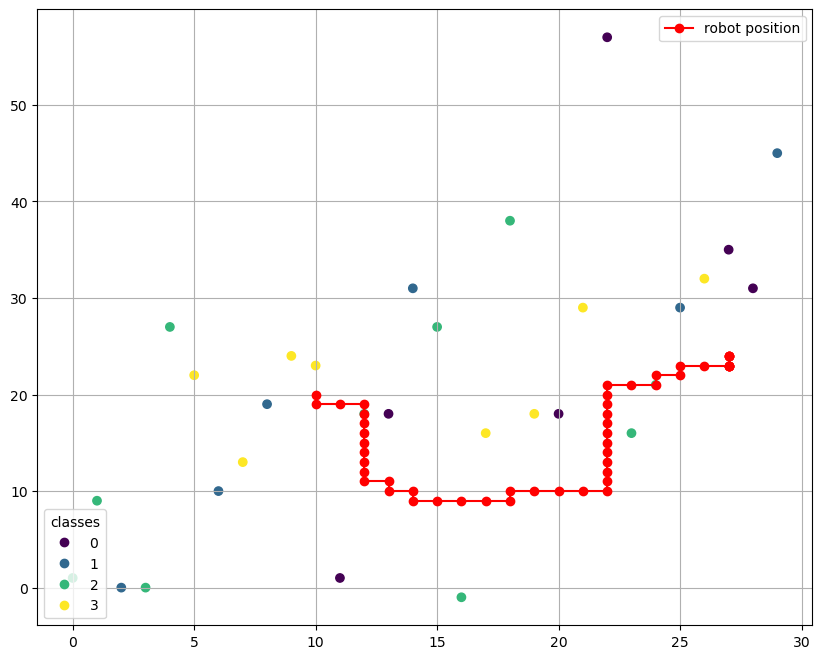

In [14]:
x = np.arange(30)
conduct_experiment(x, mean=3, std=10, k=5, n_movements=50)

**Задача 2.3 (1 балл)** Как число соседей влияет на траекторию движения робота в нашем эксперименте? Постройте четыре графика с различным числом соседей на ваш выбор. А что было бы в случае, если классы назначаются меткам не случайно, а осмысленно?

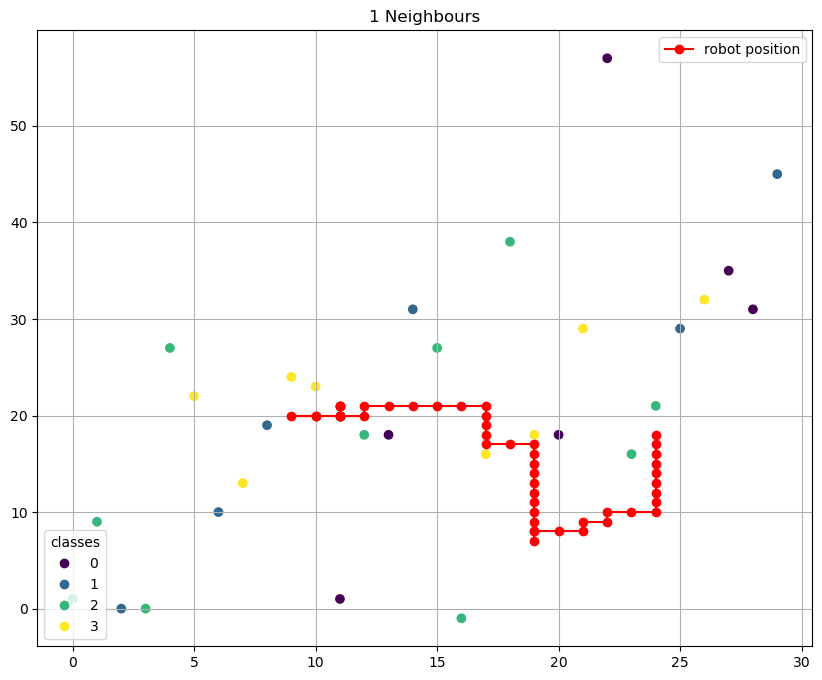

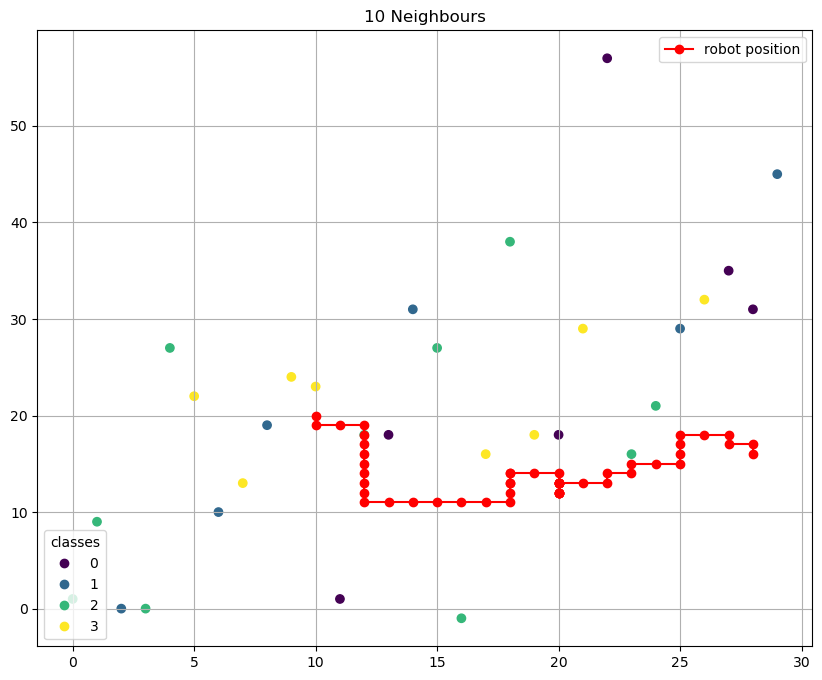

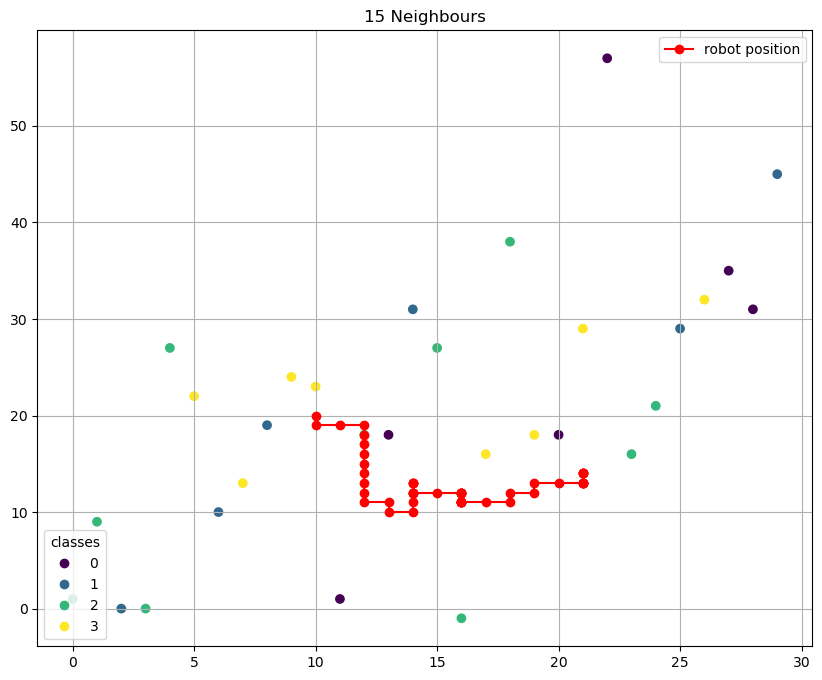

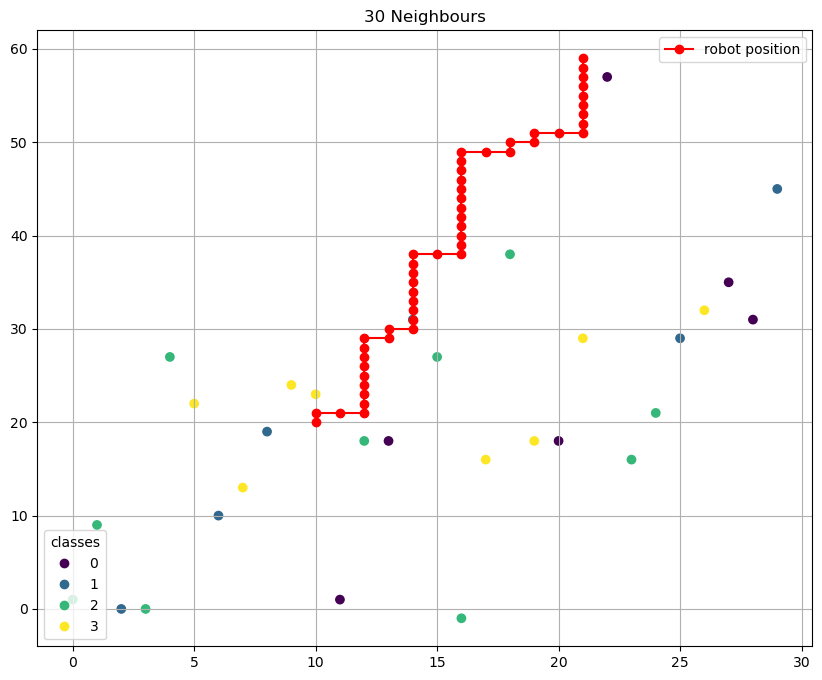

In [15]:
for k in [1, 10, 15, 30]:
    conduct_experiment(x, mean=3, std=10, k=k, n_movements=50)
    plt.title(f'{k} Neighbours')

> 1. Чем больше соседей мы рассматриваем, тем меньше позиция робота влияет на его движение - множество соседей на каждом шаге практически не меняется, поэтому движение становится более "константным". Например, при 30 соседях множество соседей становится абсолютно констаным, поэтому робот всегда двигается вверх (не считая случайного движения вправо)
> 2. Сейчас как-то адекватно интерпретировать график в принципе очень тяжело - особенно в плане проверки корректности траектории. Если бы мы могли самостоятельно расставлять необходимые метки, то появилась бы возможность создавать для робота осмысленные маршруты. Например, при 3 рассматриваемых соседях из меток можно построить своеобразный "конвеер", по которому робот сможет перемещаться

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [16]:
data = pd.read_csv('diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.

In [17]:
(data.isna() | data == '').any(axis=None)

False

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [18]:
data = data.drop(columns=['Unnamed: 0'])

> Столбец не содержит никакой информации и просто нумерует строки

**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [19]:
data.select_dtypes(exclude=object).corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


> Наибольшая коррелиация прослеживается с `carat` и размерами бриллианта (`x`, `y`, `z`)

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [20]:
data = pd.get_dummies(data=data, drop_first=True)
data

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0,1,0,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,1,0,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0,0,1,...,1,0,0,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [21]:
y = data['price']
X = data.drop(columns=['price'])
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
19497,1.21,61.3,57.0,6.92,6.87,4.23,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
31229,0.31,62.0,56.0,4.38,4.36,2.71,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
22311,1.21,62.4,57.0,6.75,6.83,4.24,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
278,0.81,62.6,55.0,5.92,5.96,3.72,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
6646,0.79,61.7,56.0,5.94,5.95,3.67,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1


**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [22]:
normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)
X_train_norm = pd.DataFrame(data=X_train_norm, columns=X.columns)
X_test_norm = pd.DataFrame(data=X_test_norm, columns=X.columns)
X_train_norm.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.862659,-0.311437,-0.207099,1.055581,0.986556,0.968253,-0.314881,1.227398,-0.585893,-0.539653,...,2.329335,-0.333294,-0.234494,-0.184885,-0.568277,-0.451216,-0.422668,-0.542475,-0.270252,3.121212
1,-1.029889,0.178549,-0.656213,-1.207734,-1.202544,-1.168276,-0.314881,1.227398,-0.585893,-0.539653,...,-0.429307,-0.333294,-0.234494,-0.184885,-0.568277,-0.451216,-0.422668,1.843403,-0.270252,-0.320388
2,0.862659,0.458541,-0.207099,0.904099,0.951670,0.982309,-0.314881,1.227398,-0.585893,-0.539653,...,-0.429307,-0.333294,-0.234494,-0.184885,-0.568277,-0.451216,2.365922,-0.542475,-0.270252,-0.320388
3,0.021527,0.598537,-1.105327,0.164512,0.192898,0.251391,-0.314881,1.227398,-0.585893,-0.539653,...,-0.429307,-0.333294,-0.234494,-0.184885,-0.568277,2.216235,-0.422668,-0.542475,-0.270252,-0.320388
4,-0.020530,-0.031445,-0.656213,0.182333,0.184176,0.181110,-0.314881,1.227398,-0.585893,-0.539653,...,-0.429307,3.000353,-0.234494,-0.184885,-0.568277,-0.451216,-0.422668,-0.542475,-0.270252,3.121212


**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linreg_model = LinearRegression().fit(X_train_norm, y_train)

mean_squared_error(y_train, linreg_model.predict(X_train_norm))

1290541.9147450617

In [24]:
mean_squared_error(y_test, linreg_model.predict(X_test_norm))

1244765.4357158698

**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [25]:
pd.DataFrame(linreg_model.coef_, index=X.columns)

,0
carat,5338.615671
depth,-90.173817
table,-60.332280
x,-1100.418850
y,-6.458917
z,-34.258945
cut_Good,170.602933
cut_Ideal,414.369515
cut_Premium,339.239204
cut_Very Good,310.654256


> Наиболее выделяются признаки `carat`, `x` и `clarity` (в частности `clarity_VS2`)

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [26]:
from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=10).fit(X_train_norm, y_train)
pd.DataFrame(lasso_model.coef_, index=X.columns)

,0
carat,4831.596261
depth,-96.516853
table,-71.937944
x,-651.185193
y,-0.000000
z,-28.494759
cut_Good,46.135965
cut_Ideal,206.837676
cut_Premium,151.391271
cut_Very Good,139.241494


In [27]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=10).fit(X_train_norm, y_train)
pd.DataFrame(ridge_model.coef_, index=X.columns)

,0
carat,5299.360461
depth,-88.383025
table,-60.576796
x,-1057.321756
y,-9.148025
z,-37.568864
cut_Good,171.203364
cut_Ideal,415.480169
cut_Premium,340.215934
cut_Very Good,312.016066


> Единственное сильное различие в весах обнаружилось при Lasso-регуляризации, где коэффициенты `clarity` значительно уменьшились, а `y` вес полностью обнулился - его можно вычислить, зная `x`, `z` и `depth`, поэтому новой информации он не несет (как и любой из этих трех, если известны остальные - видимо `y` просто не повезло)

> Учитывая, однако, что и при обычной линейной регрессии коэффициент `y` был достаточно мал, существующая мультиколлинеарность проявлена довольно слабо и скорее всего не оказывает особого влияния на эффективность модели

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

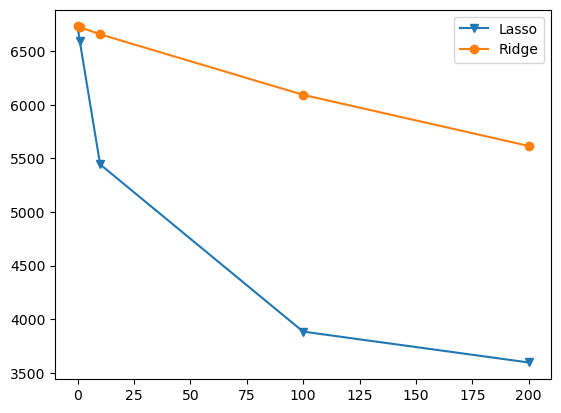

In [28]:
lasso_score = []
ridge_score = []
alphas = [0.1, 1, 10, 100, 200]
for a in alphas:
    lasso_score.append(np.linalg.norm(Lasso(alpha=a).fit(X_train_norm, y_train).coef_))
    ridge_score.append(np.linalg.norm(Ridge(alpha=a).fit(X_train_norm, y_train).coef_))

plt.plot(alphas, lasso_score, label='Lasso', marker='v')
plt.plot(alphas, ridge_score, label='Ridge', marker='o')
plt.legend()
plt.show()

> По графику становится очевидно, что Lasso-регрессия гораздо агрессивнее уменьшает веса - при $\alpha = 10$ Lasso-регрессия достигает более низких весов, чем Ridge-регрессия при $\alpha = 200$
Такая 'агрессия' приводит к тому, что веса у малоинформативных признаков практически зануляются, что позволяет легко их идентифицировать

**Задача 3.11 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

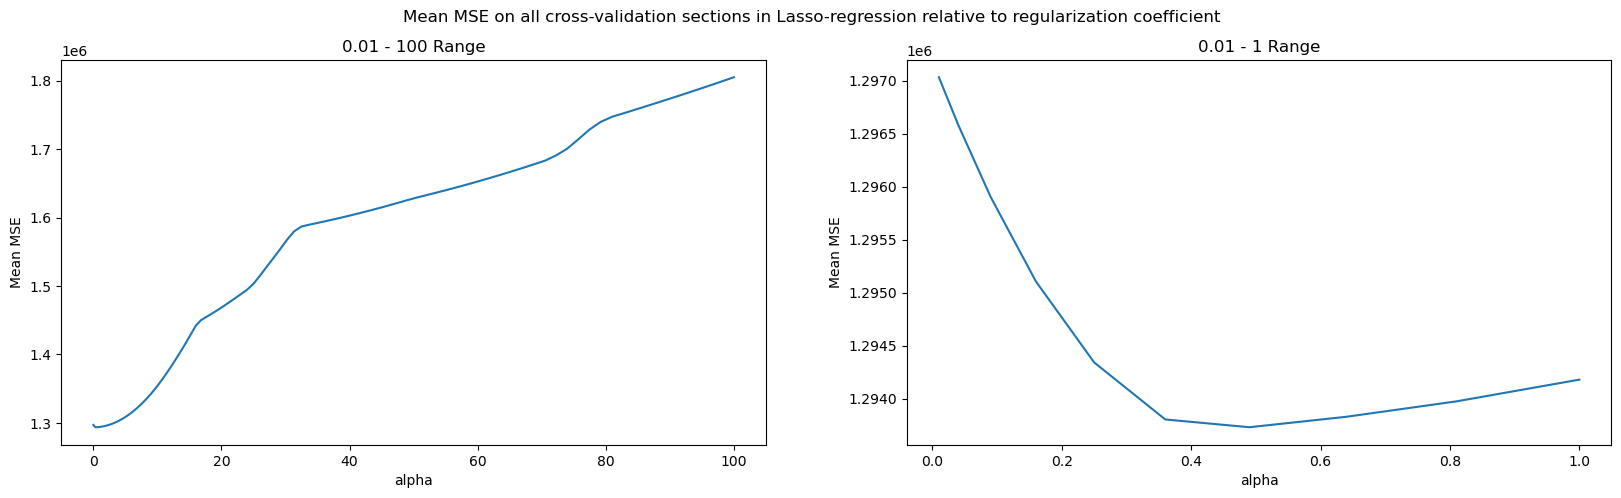

In [29]:
from sklearn.linear_model import LassoCV

lassoCV_model = LassoCV(cv=5, alphas=np.linspace(0.1, 10, 100) ** 2, max_iter=10000).fit(X_train_norm, y_train)
# при дефолтном ограничении итераций выводит ConvergenceWarning

t = np.array(sorted(zip(lassoCV_model.alphas_,
                        np.mean(lassoCV_model.mse_path_, axis=1))))

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(t[:, 0], t[:, 1])
plt.xlabel('alpha')
plt.ylabel('Mean MSE')
plt.title('0.01 - 100 Range')

plt.subplot(1, 2, 2)
plt.plot(t[:10, 0], t[:10, 1])
plt.xlabel('alpha')
plt.ylabel('Mean MSE')
plt.title('0.01 - 1 Range')

plt.suptitle('Mean MSE on all cross-validation sections in Lasso-regression relative to regularization coefficient')
plt.show()

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [30]:
lasso_optimized_model = Lasso(alpha=0.5).fit(X_train_norm, y_train)
pd.DataFrame(lasso_optimized_model.coef_, index=X.columns)

,0
carat,5313.176903
depth,-90.448197
table,-60.897186
x,-1079.642886
y,-4.145545
z,-34.162519
cut_Good,164.415304
cut_Ideal,404.074256
cut_Premium,329.935829
cut_Very Good,302.134378


> Наиболее информативными оказались, ожидаемо:
> 1. `carat`
> 2. Размеры - причем только `x` - скорее всего остальные размеры пропорциональны, поэтому особой необходимости в них нет
> 3. `clarity`. Неожиданно порядок весов у классов не соответствует ранжированию из описания данных

> Наименее информативными оказались `depth` и `table` - в некоторой степени они также являются производными от размера, поэтому предоставляют не так много новой информации. Порядок весов у их классов, однако, соответствует порядку из описания датасета

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [31]:
mean_squared_error(y_test, lasso_optimized_model.predict(X_test_norm))

1244202.8005539959

> Итого получаем:
Linear Regression 1244765.43571587
Lasso Regression with optimal parameters 1244202.8005539959
В результате мы уменьшили MSE на ***астрономические*** ~0,05% (мдэ)

> Как и ожидалось, низкая мультиколлинеарность не оказала никакого существенного влияния на эффективность модели
Однако важно понимать, что это всего лишь один конкретный случай. При другом разбиении данных результаты уже могут кардинально отличаться, что говорить про новые данные или другие датасеты. Даже в нашем случае при использовании Lasso-регрессии какой-никакой прирост эффективности мы все-таки получили, а в случаях с более явной мультиколлинеарностью этот прирост может быть на порядки выше.

> Таким образом из рассмотренных нами моделей наиболее эффективной выглядит Lasso-регрессия с кросс-валидацией и подобором коэффициента регуляризации